Topics to cover:

- One-Hot Encoding
- Discretizing: equally-sized bins + equal-frequency bins
- ~~Interaction terms and/or polynomial features? (optional)~~
- Feature scaling: normalizing, standardizing, robust scaling (robust standardization)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In this demo we're going to see some feature engineering and scaling techniques in action.

In [2]:
data = pd.read_csv("cali_housing_modified_cleaned.csv")

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200.0,NEAR BAY


In [4]:
# one-hot encoding the ocean_proximity column
data = pd.get_dummies(data, columns=["ocean_proximity"])

Here again, to do the exact same thing using scikit-learn so that it could be embedded into a pipeline, we would say do this:


In [5]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder()
# ocn_prox_encoded = encoder.fit_transform(data[["ocean_proximity"]])
# # `data_encoded` is a sparse matrix; needs to be converted to a DataFrame
# ocn_prox_encoded_df = pd.DataFrame(ocn_prox_encoded.toarray(), columns=encoder.categories_)
# # Stick these new columns back onto the original dataframe and drop the original
# data = pd.concat([data, ocn_prox_encoded_df], axis=1)
# data.drop(columns=["ocean_proximity"], inplace=True)

# # Specify better names for the new columns
# data.columns = data.columns.tolist()[:-5] + [
#     "ocean_proximity_<1H OCEAN",
#     "ocean_proximity_INLAND",
#     "ocean_proximity_ISLAND",
#     "ocean_proximity_NEAR BAY",
#     "ocean_proximity_NEAR OCEAN",
# ]

In [6]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200.0,False,False,False,True,False


One problem: We now have multicollinearity because one column is redundant. This could spell trouble for some types of models. So we should have done:

In [7]:
# Reload the data
data = pd.read_csv("cali_housing_modified_cleaned.csv")
# one-hot encoding the ocean_proximity column
data = pd.get_dummies(data, columns=["ocean_proximity"], drop_first=True)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600.0,False,False,True,False
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500.0,False,False,True,False
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100.0,False,False,True,False
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300.0,False,False,True,False
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200.0,False,False,True,False


And similarly, scikit-learn's OneHotEncoder has a `drop` parameter which we would set to `"first"`:

In [8]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(drop="first")
# ocn_prox_encoded = encoder.fit_transform(data[["ocean_proximity"]])
# # `data_encoded` is a sparse matrix; needs to be converted to a DataFrame
# ocn_prox_encoded_df = pd.DataFrame(ocn_prox_encoded.toarray(), columns=encoder.categories_)
# # Stick these new columns back onto the original dataframe and drop the original
# data = pd.concat([data, ocn_prox_encoded_df], axis=1)
# data.drop(columns=["ocean_proximity"], inplace=True)

# # Specify better names for the new columns
# data.columns = data.columns.tolist()[:-5] + [
#     "ocean_proximity_<1H OCEAN",
#     "ocean_proximity_INLAND",
#     "ocean_proximity_ISLAND",
#     "ocean_proximity_NEAR BAY",
#     "ocean_proximity_NEAR OCEAN",
# ]

Next, let's talk about discretization. Maybe we don't care about the exact value of median income or median age, but rather, we just want to know what ranges they fall in if we cut the entire range into 5 pieces. There are 3 different ways to discretize a continuous feature:
- We can use equally sized bins, which yields 5 bins of identical widths,
- or equal _frequency_ bins so that all bins have the same numebr of samples,
- or we can use k-means clustering which is a more advanced algorithm.  

Let's discretize `median_income` into equally-sized bins.

In [9]:
from sklearn.preprocessing import KBinsDiscretizer

# Alternative: use `pandas.cut()`
discretizer = KBinsDiscretizer(n_bins=5, strategy="uniform", encode="ordinal")

housing_median_age_binned = discretizer.fit_transform(data[["median_income"]])

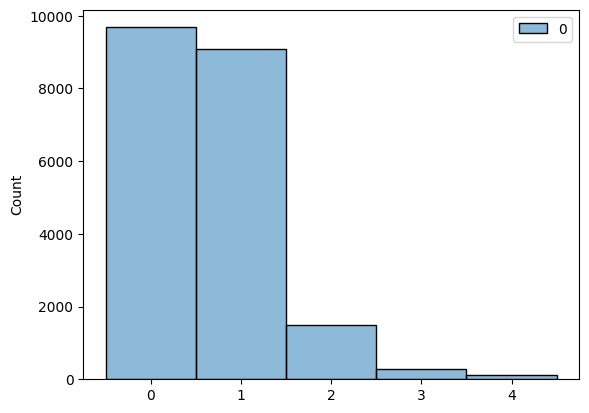

In [10]:
# data["median_income"] = pd.DataFrame(housing_median_age_binned)
sns.histplot(housing_median_age_binned, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xticks(range(5))
plt.show()

Now let's use equal-frequency binning to see how it compares to equal width binning.

In [11]:
# Alternative: use `pandas.qcut()`
discretizer = KBinsDiscretizer(n_bins=5, strategy="quantile", encode="ordinal")

median_income_binned = discretizer.fit_transform(data[["median_income"]])

In [12]:
data["median_income"] = pd.DataFrame(median_income_binned)
data["median_income"].value_counts()

median_income
2.0    4131
4.0    4128
3.0    4128
1.0    4127
0.0    4125
Name: count, dtype: int64

Last but not least, let's discuss scaling. Remember: to avoid train-test contamination, which is a form of data leakage, we should always scale features after splitting the data, otherwise there will be some information about the test set mixed in with the training set. So in practice, we'd fit the scaler to the training set and then transform both the train and test sets using the same fitted scaler. But since this is just a demonstration of feature scaling, we won't split the data right now.   
Okay, let's take a look at the data again...

In [13]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41,880,129.0,322,126,4.0,452600.0,False,False,True,False
1,-122.22,37.86,21,7099,1106.0,2401,1138,4.0,358500.0,False,False,True,False
2,-122.24,37.85,52,1467,190.0,496,177,4.0,352100.0,False,False,True,False
3,-122.25,37.85,52,1274,235.0,558,219,4.0,341300.0,False,False,True,False
4,-122.25,37.85,52,1627,280.0,565,259,2.0,342200.0,False,False,True,False


Looking good so far. The values in each column occupy vastly differnt ranges. Median income has units of $10K whereas house values are in absolute dollars. ML models that are distance-based will severly undeperform if the features are not scaled.  
The choice of scaling method is really up to us. Let's see the three main ones in practice.  
I'm going to use Min-Max Scaling AKA Normalization on total rooms... This basically just shrinks the values so that they all fall between 0 and 1 but the ratios between them doesn't change.

In [14]:
from sklearn.preprocessing import MinMaxScaler
data["total_rooms"] = MinMaxScaler().fit_transform(data[["total_rooms"]])
data["total_rooms"].describe()

count    20639.000000
mean         0.066987
std          0.055488
min          0.000000
25%          0.036764
50%          0.054046
75%          0.080014
max          1.000000
Name: total_rooms, dtype: float64

Let's use Standardization on the median age column. This puts the values on a Standard Gaussian curve and is good for data that is more or less normally distributed to begin with.

<Axes: >

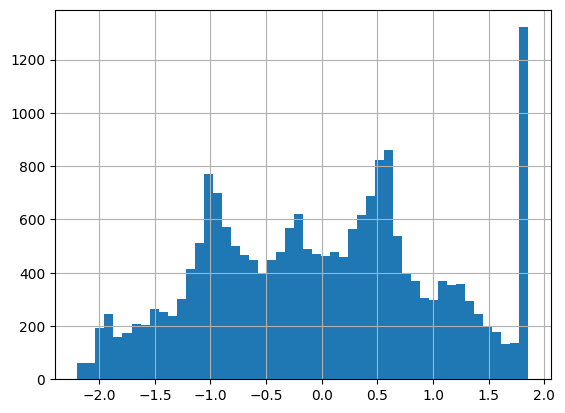

In [15]:
from sklearn.preprocessing import StandardScaler
data["housing_median_age"] = StandardScaler().fit_transform(data[["housing_median_age"]])
data["housing_median_age"].hist(bins=50)

Now the values are centered around zero with a standard deviation of one. But evidently they were not really normally distributed. Especially when we have a lot of outliers, robust scaling is preferred...

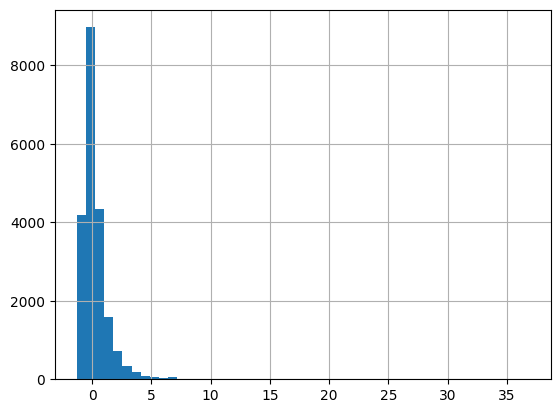

In [16]:
from sklearn.preprocessing import RobustScaler
data["population"] = RobustScaler().fit_transform(data[["population"]])
data["population"].hist(bins=50);

We went from values in the 10s of thousands range to much smaller values.

Two points to note:
> One is that in practice you usually want to use the same scaler for all features, especially if they have similar distributions. If you recall from the first demo, a number of our features all had very similar distributions, so we should use the same scaler on them.  

> The other one is that generally scaling the target variable is not as critically important as scaling features, but especially in regression tasks it helps numerical stability, especially if we're dealing with very small or very large numbers.